# Twitter Ratio

This folder contains data behind the story [The Worst Tweeter In Politics Isn’t Trump](https://fivethirtyeight.com/features/the-worst-tweeter-in-politics-isnt-trump/).

`senators.csv` contains tweets from all senators collected on Oct. 19 and 20.

`BarackObama.csv` contains tweets from [@BarackObama](https://twitter.com/BarackObama) collected on Oct. 20.

`realDonaldTrump.csv` contains tweets from [@realDonaldTrump](https://twitter.com/realDonaldTrump) collected on Oct. 23.

## Senator Tweets

We'll start of by looking at the `senators.csv` dataset.

In [1]:
# The usual suspects ...
import logging
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cleaner2 as clr

# And their accomplices ...
from gensim import corpora
from gensim import models
from gensim import similarities
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from collections import defaultdict
from sklearn.cluster import KMeans
from time import time

# Settings
sns.set(context='notebook', style='whitegrid', palette='deep', rc=None)
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# Reading in the data
tweets = pd.read_csv('senators.csv', encoding="ISO-8859-1")
tweets.shape

(288615, 10)

In [3]:
# Top 5 rows
tweets.head()

,created_at,text,url,replies,retweets,favorites,user,bioguide_id,party,state
0,10/19/17 21:47,We released bipartisan healthcare bill today &...,https://twitter.com/amyklobuchar/status/921130...,21,129,533,amyklobuchar,K000367,D,MN
1,10/19/17 18:48,I spoke with @Morning_Joe team abt #HonestAds ...,https://twitter.com/amyklobuchar/status/921085...,8,46,150,amyklobuchar,K000367,D,MN
2,10/19/17 18:14,Lots of interest in my bill with Senators Warn...,https://twitter.com/amyklobuchar/status/921077...,36,227,932,amyklobuchar,K000367,D,MN
3,10/19/17 18:04,"Today's the day @MarkWarner, @SenJohnMcCain &a...",https://twitter.com/amyklobuchar/status/921074...,17,167,550,amyklobuchar,K000367,D,MN
4,10/19/17 16:33,".@MarkWarner, @SenJohnMcCain &amp; I put toget...",https://twitter.com/amyklobuchar/status/921051...,31,279,893,amyklobuchar,K000367,D,MN


### Exploration

In [4]:
tweets.dtypes

created_at     object
text           object
url            object
replies         int64
retweets        int64
favorites       int64
user           object
bioguide_id    object
party          object
state          object
dtype: object

Text(0,0.5,'Density')

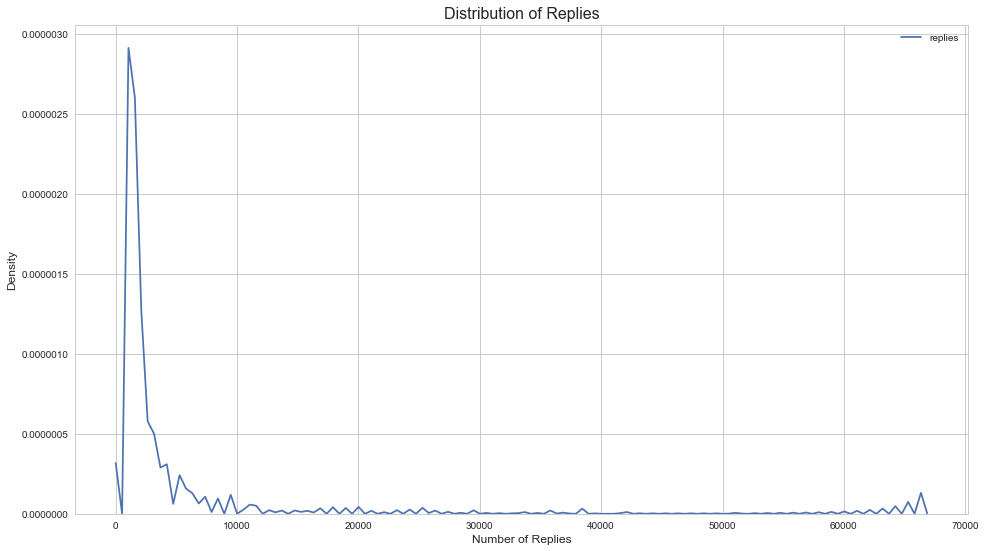

In [5]:
# Distribution of replies
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.replies)
plt.title('Distribution of Replies', fontsize=16)
plt.xlabel('Number of Replies', fontsize=12)
plt.ylabel('Density', fontsize=12)

Text(0,0.5,'Density')

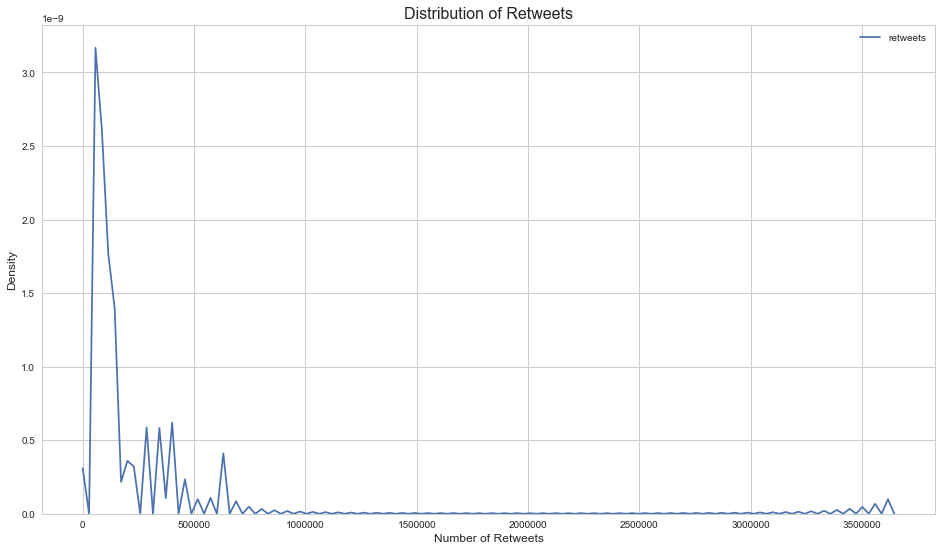

In [6]:
# Distribution of retweets
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.retweets)
plt.title('Distribution of Retweets', fontsize=16)
plt.xlabel('Number of Retweets', fontsize=12)
plt.ylabel('Density', fontsize=12)

Text(0,0.5,'Density')

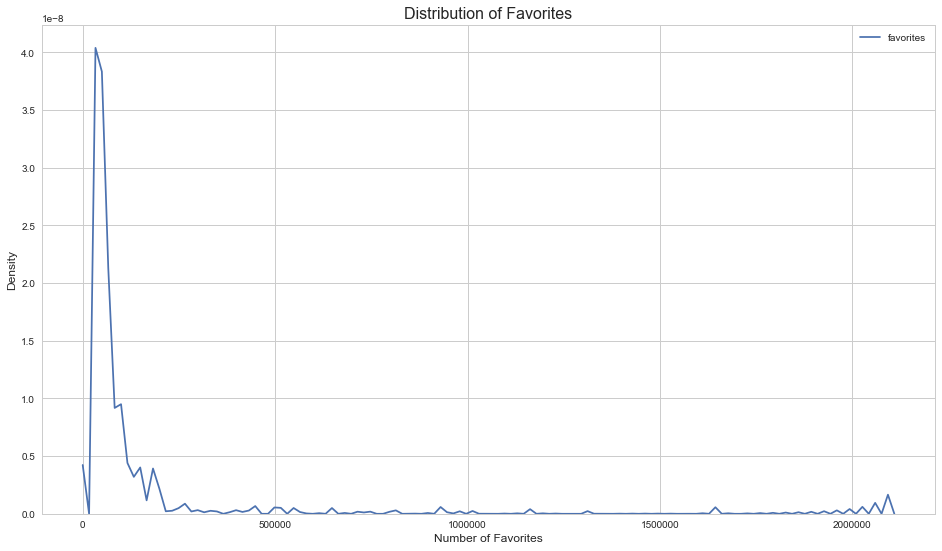

In [7]:
# Distribution of favourites
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.favorites)
plt.title('Distribution of Favorites', fontsize=16)
plt.xlabel('Number of Favorites', fontsize=12)
plt.ylabel('Density', fontsize=12)

Text(0,0.5,'Retweets')

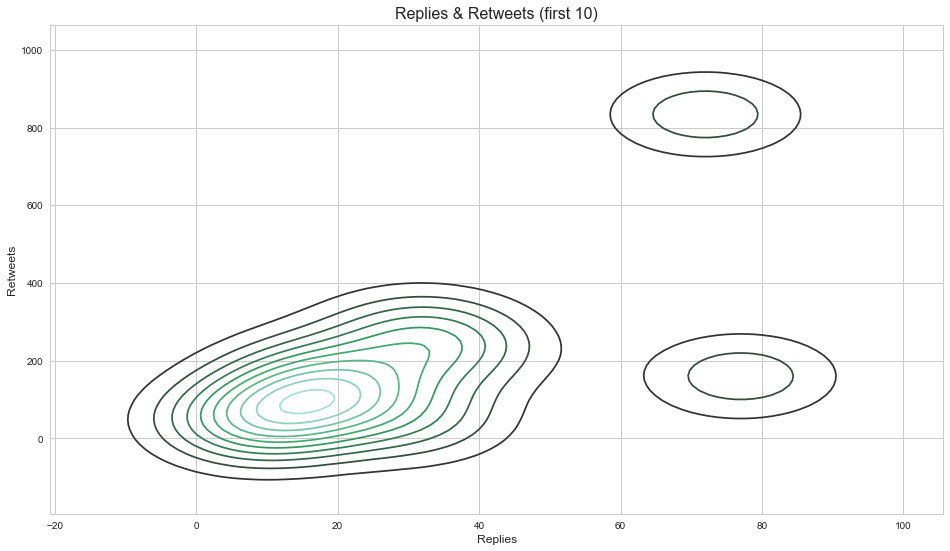

In [8]:
# Replies-Retweets
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.replies[:10].dropna(), tweets.retweets[:10].dropna())
plt.title('Replies & Retweets (first 10)', fontsize=16)
plt.xlabel('Replies', fontsize=12)
plt.ylabel('Retweets', fontsize=12)

Text(0,0.5,'Retweets')

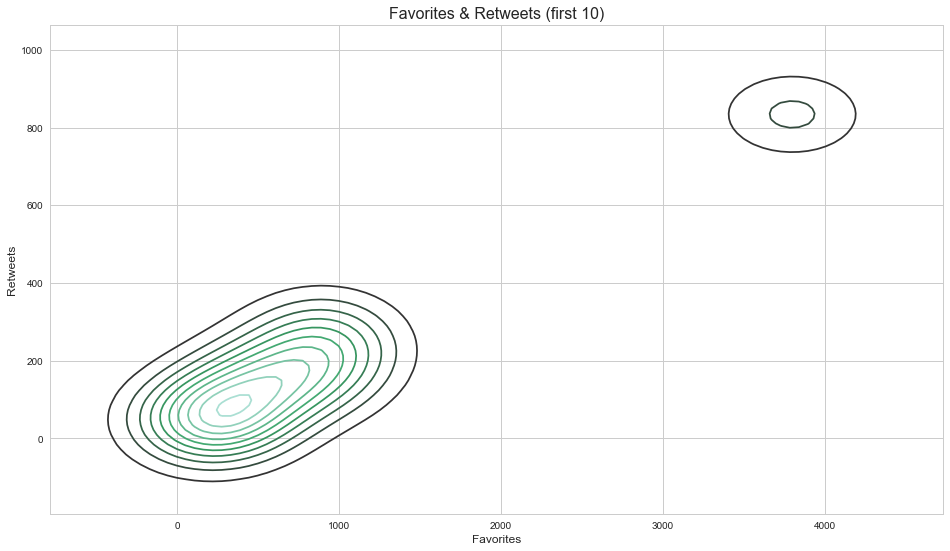

In [9]:
# Favourites-Retweets
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.favorites[:10].dropna(), tweets.retweets[:10].dropna())
plt.title('Favorites & Retweets (first 10)', fontsize=16)
plt.xlabel('Favorites', fontsize=12)
plt.ylabel('Retweets', fontsize=12)

Text(0,0.5,'Favorites')

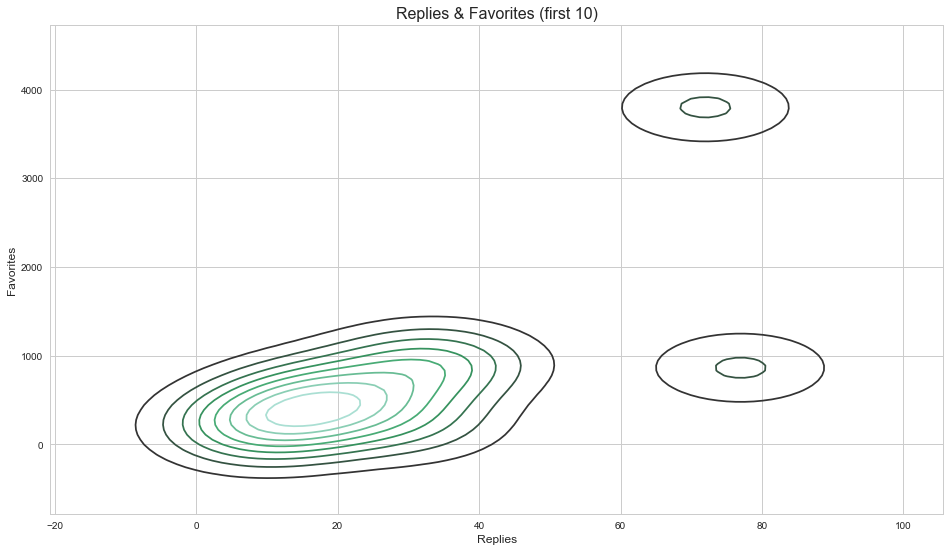

In [10]:
# Replies-Favorites
plt.figure(figsize=(16, 9))
sns.kdeplot(tweets.replies[:10].dropna(), tweets.favorites[:10].dropna())
plt.title('Replies & Favorites (first 10)', fontsize=16)
plt.xlabel('Replies', fontsize=12)
plt.ylabel('Favorites', fontsize=12)

Text(0.5,0,'Count')

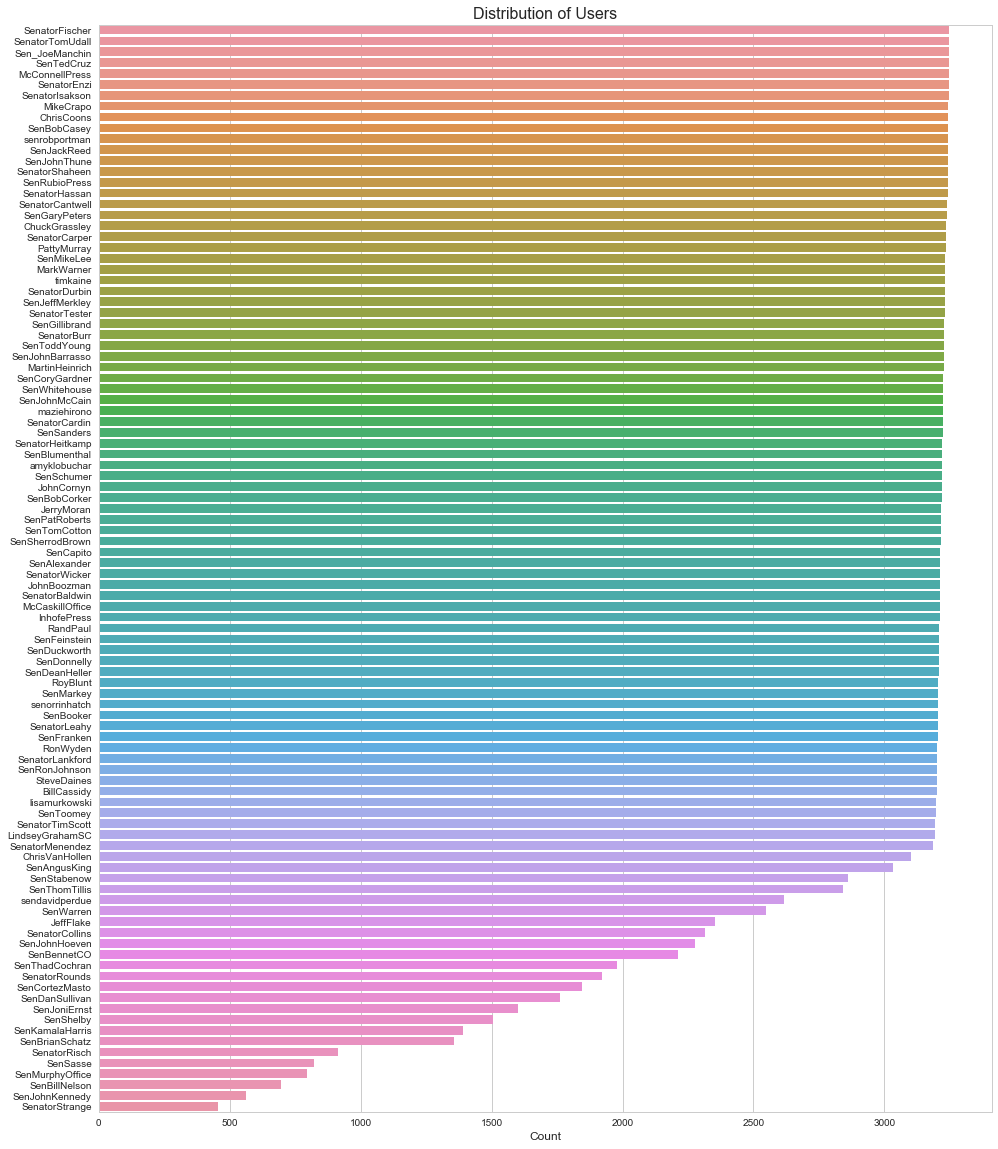

In [11]:
# Distribution of users
plt.figure(figsize=(16, 20))
sns.countplot(y=tweets.user, order=tweets.user.value_counts().index)
plt.title('Distribution of Users', fontsize=16)
plt.ylabel('')
plt.xlabel('Count', fontsize=12)

Text(0.5,0,'Replies')

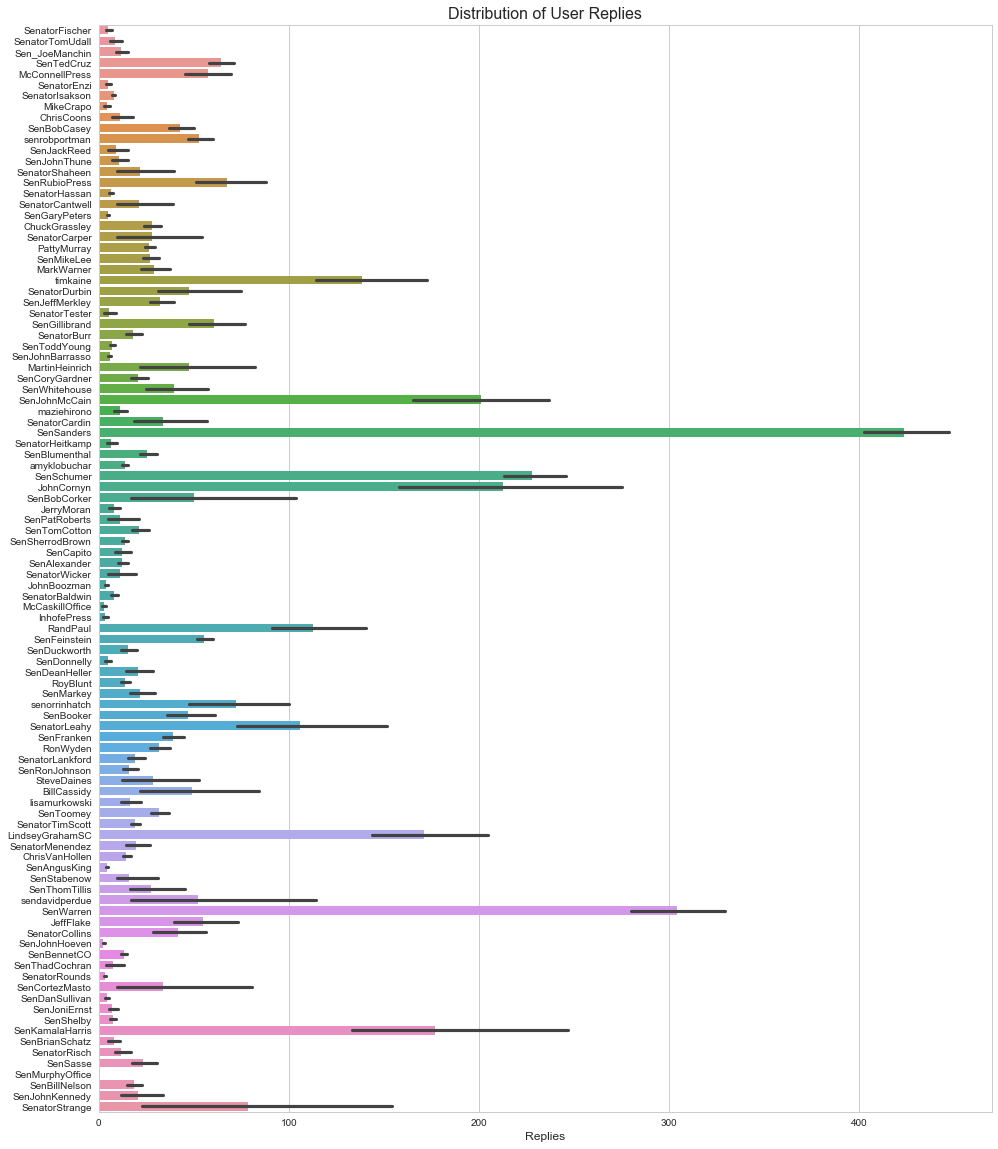

In [12]:
# Distribution of user replies
plt.figure(figsize=(16, 20))
sns.barplot(x=tweets.replies, y=tweets.user, order=tweets.user.value_counts().index)
plt.title('Distribution of User Replies', fontsize=16)
plt.ylabel('')
plt.xlabel('Replies', fontsize=12)

Text(124,0.5,'')

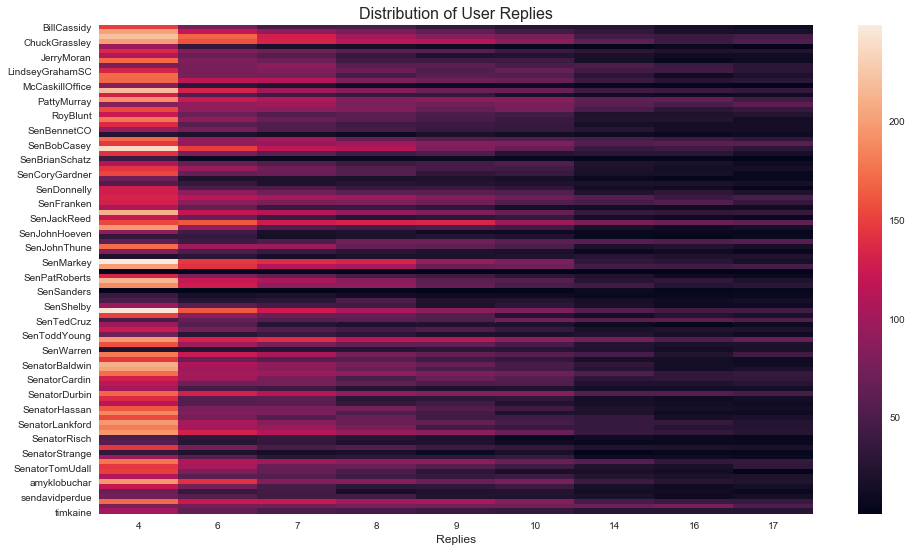

In [13]:
# Distribution of user replies
a = tweets.groupby(['user', 'replies'])['user'].count().unstack('replies').dropna(axis=1, how='any')
plt.figure(figsize=(16, 9))
sns.heatmap(a)
plt.title('Distribution of User Replies', fontsize=16)
plt.xlabel('Replies', fontsize=12)
plt.ylabel('')

Text(124,0.5,'')

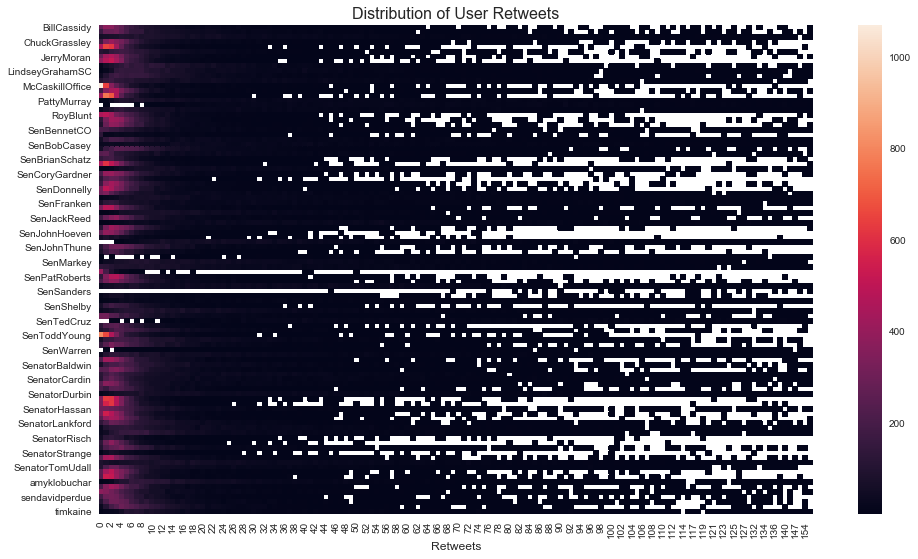

In [14]:
# Distribution of user retweets
a = tweets.groupby(['user', 'retweets'])['user'].count().unstack('retweets').dropna(axis=1, how='all')

# Cleaning the matrix
_removeColumn = list()
for column in a.columns:
    # 1. Number of unique items the columns contains:
    if (len(a[column].unique()) == 1):
        _removeColumn.append(column)
        # 2. Number of missing values:
    elif (a[column].isnull().sum() > ((a.shape[0])/2)):
        _removeColumn.append(column)

# Removing the columns
deleteColumn = (x for x in _removeColumn)
try:
    while True:
        del a[deleteColumn.__next__()]
except StopIteration:
    pass

# Plotting
plt.figure(figsize=(16, 9))
sns.heatmap(a)
plt.title('Distribution of User Retweets', fontsize=16)
plt.xlabel('Retweets', fontsize=12)
plt.ylabel('')

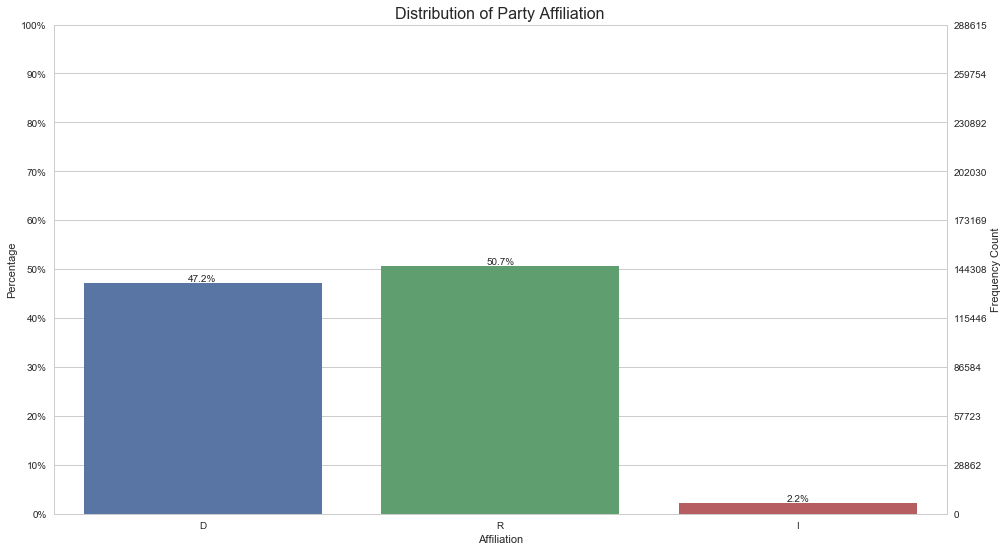

In [15]:
# Distribution of party affiliations
clr.frequency_plot(dataframe=tweets, 
                   x='party',
                   title='Distribution of Party Affiliation',
                   xlabel='Affiliation')

Text(0,0.5,'Count')

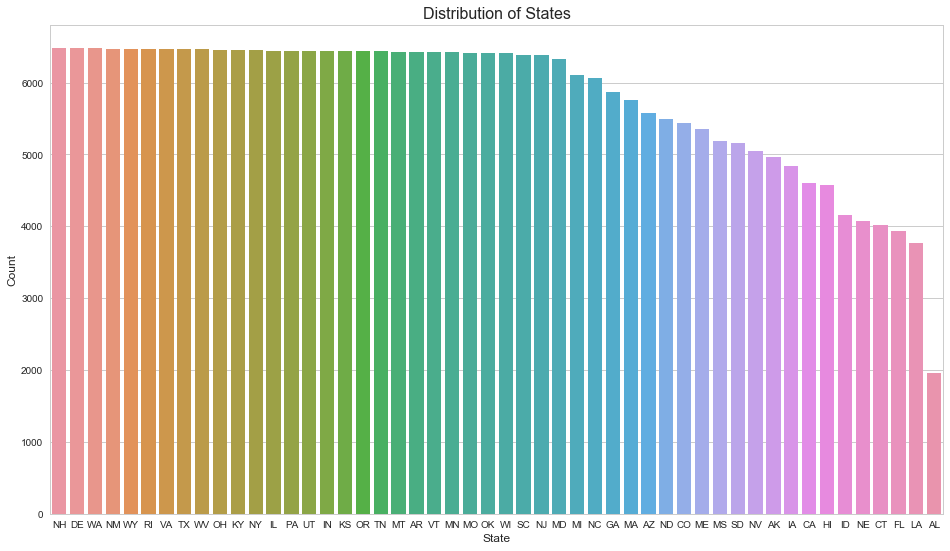

In [16]:
# Distribution of states
sns.countplot(tweets.state, order=tweets.state.value_counts().index)
plt.title('Distribution of States', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Count', fontsize=12)

(array([  0.5,   2.5,   4.5,   6.5,   8.5,  10.5,  12.5,  14.5,  16.5,
         18.5,  20.5,  22.5,  24.5,  26.5,  28.5,  30.5,  32.5,  34.5,
         36.5,  38.5,  40.5,  42.5,  44.5,  46.5,  48.5]),
 <a list of 25 Text yticklabel objects>)

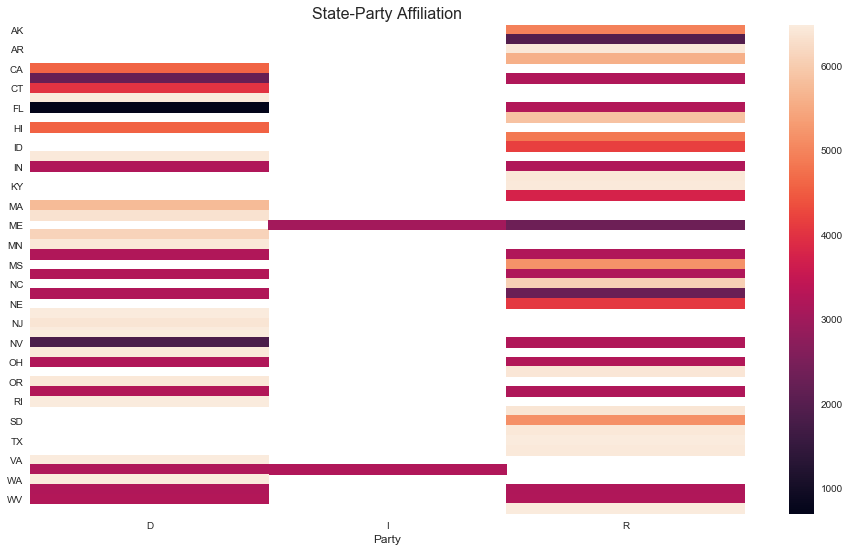

In [17]:
# State-Party
a = tweets.groupby(['state', 'party'])['state'].count().unstack('party')
sns.heatmap(a)
plt.title('State-Party Affiliation', fontsize=16)
plt.xlabel('Party', fontsize=12)
plt.ylabel('')
plt.yticks(rotation=0)

(array([  0.5,   2.5,   4.5,   6.5,   8.5,  10.5,  12.5,  14.5,  16.5,
         18.5,  20.5,  22.5,  24.5,  26.5,  28.5,  30.5,  32.5,  34.5,
         36.5,  38.5,  40.5,  42.5,  44.5,  46.5,  48.5]),
 <a list of 25 Text yticklabel objects>)

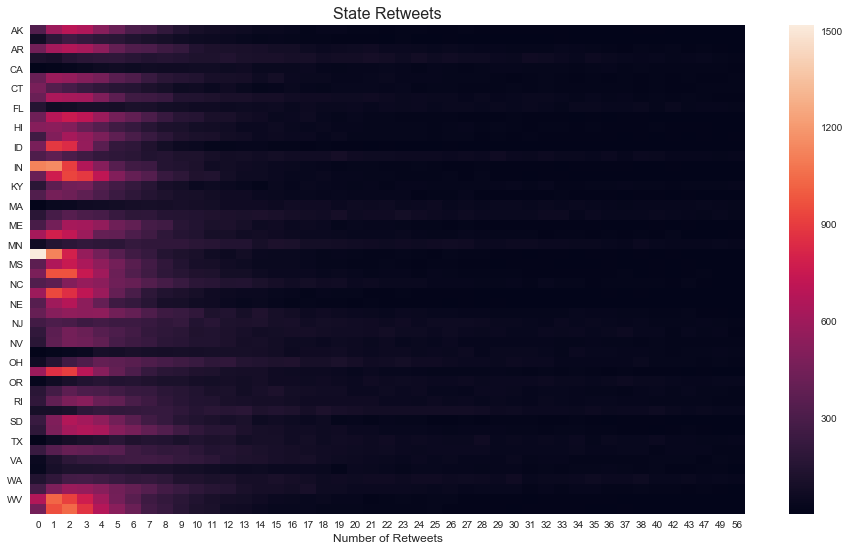

In [18]:
# State-Retweets
a = tweets.groupby(['state', 'retweets'])['retweets'].count().unstack('retweets').dropna(axis=1, how='any')
sns.heatmap(a)
plt.title('State Retweets', fontsize=16)
plt.xlabel('Number of Retweets', fontsize=12)
plt.ylabel('')
plt.yticks(rotation=0)

(array([  0.5,   2.5,   4.5,   6.5,   8.5,  10.5,  12.5,  14.5,  16.5,
         18.5,  20.5,  22.5,  24.5,  26.5,  28.5,  30.5,  32.5,  34.5,
         36.5,  38.5,  40.5,  42.5,  44.5,  46.5,  48.5]),
 <a list of 25 Text yticklabel objects>)

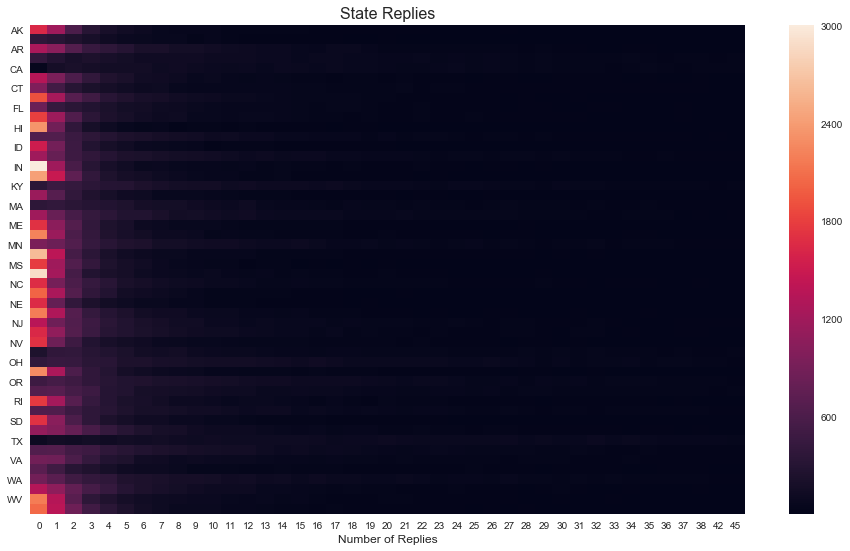

In [19]:
# State-Replies
a = tweets.groupby(['state', 'replies'])['replies'].count().unstack('replies').dropna(axis=1, how='any')
sns.heatmap(a)
plt.title('State Replies', fontsize=16)
plt.xlabel('Number of Replies', fontsize=12)
plt.ylabel('')
plt.yticks(rotation=0)

### Time Series

In [58]:
# Converting 'created_at' to datetime format
tweets['created_at'] = pd.to_datetime(tweets['created_at'], yearfirst=True, exact=False)

# Subsetting
tweets_subset = tweets.loc[(tweets['created_at'].dt.year > 2016)]
tweets_subset = tweets_subset.sort_values(by='created_at')

In [59]:
def create_series(data, time_column, category_column):
    return data.set_index(time_column)[category_column]

In [60]:
a = create_series(data=tweets_subset, time_column='created_at', category_column='replies')

In [61]:
# Plotting a time series object
def plot_series(data, title='', ylabel='', color='blue'):
    '''Plotting a time series object.'''
    # Size of the plot
    plt.figure(figsize=(22, 10))
    # Removing plot-frame lines
    ax = plt.subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    # Limiting the plot-range
    ax.set_xlim(data.index.min(), data.index.max())
    ax.set_ylim(data.values.min(), data.values.max())
    # Trace lines
    for i in range(int(data.values.min()+data.values.max()/2), int(data.values.max()+1), int(data.values.max()/10)):
        plt.plot(range(data.index.year.min(), data.index.year.max()), 
                 [i]*len(range(data.index.year.min(), data.index.year.max())),
                 '--', lw=.5, color='grey', alpha=.3)
    # Removing tick marks
    ax.tick_params(axis='both', which='both', 
                    bottom=False, top=False,
                    labelbottom=True, labelleft=True,
                    left=False, right=False)
    # Plot labels
    ax.set_ylabel(ylabel, fontsize=16)
    # Plotting
    ax.plot(data, color=color)

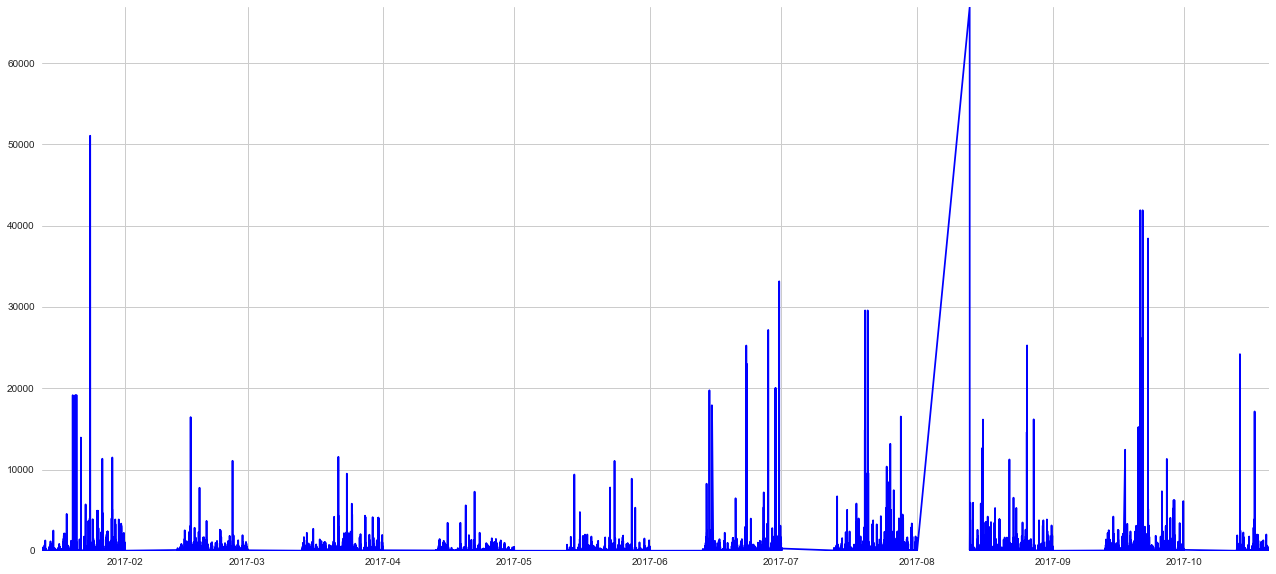

In [62]:
plot_series(a)

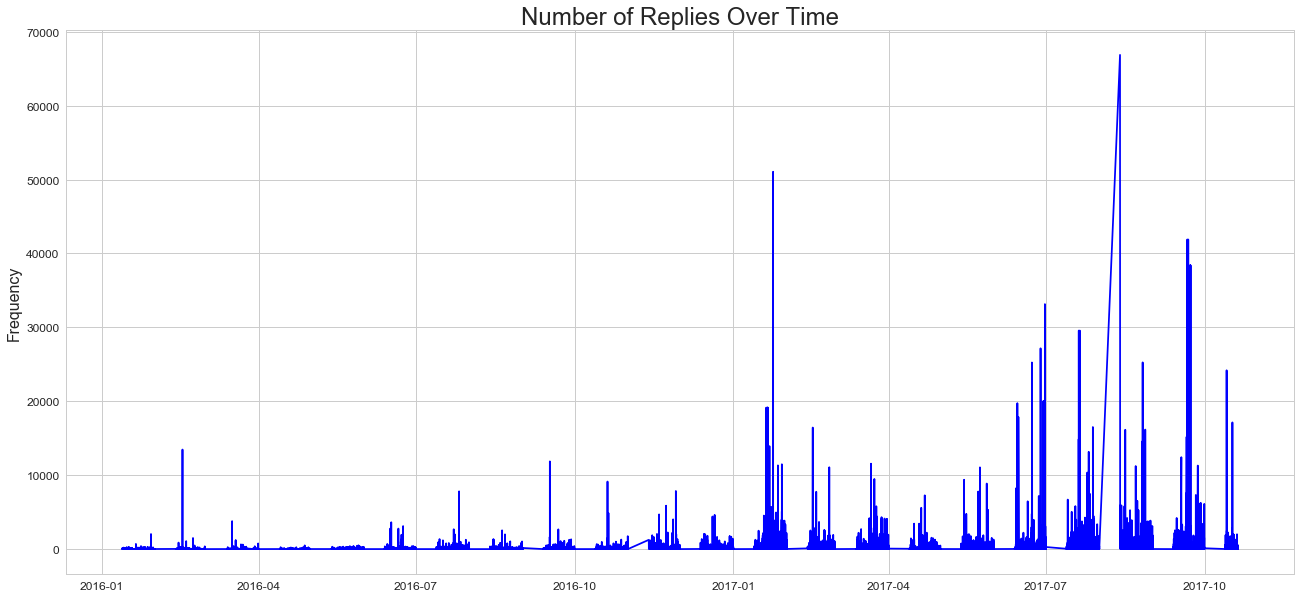

In [21]:
# Plotting function
def plot_series(series, title=None, color='blue'):
    plt.figure(figsize=(22, 10))
    plt.plot(series, color=color)
    plt.title(title, fontsize=24)
    plt.xticks(fontsize=12)
    plt.ylabel('Frequency', fontsize=16)
    plt.yticks(fontsize=12)

# Creating the tweet replies series
s = tweets_subset[['created_at', 'replies']]
replies = s.set_index('created_at')['replies']

# Number of tweet replies over time
plot_series(replies, title='Number of Replies Over Time')

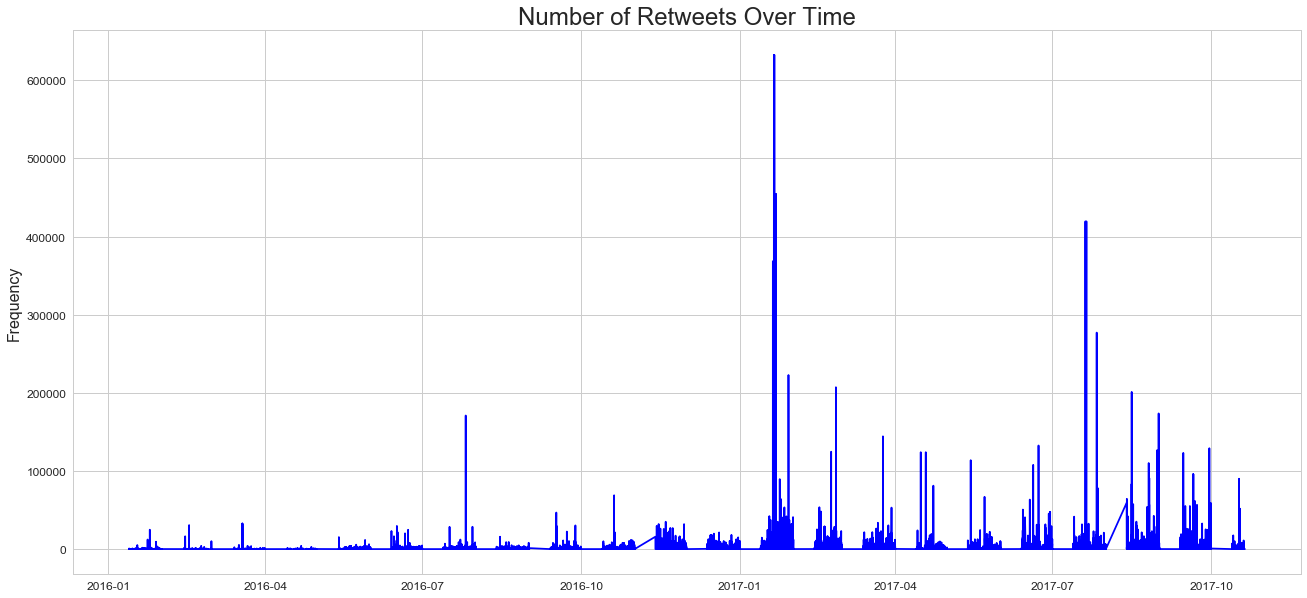

In [22]:
# Creating the retweet series
s = tweets_subset[['created_at', 'retweets']]
retweets = s.set_index('created_at')['retweets']

# Number of retweets over time
plot_series(retweets, title='Number of Retweets Over Time')

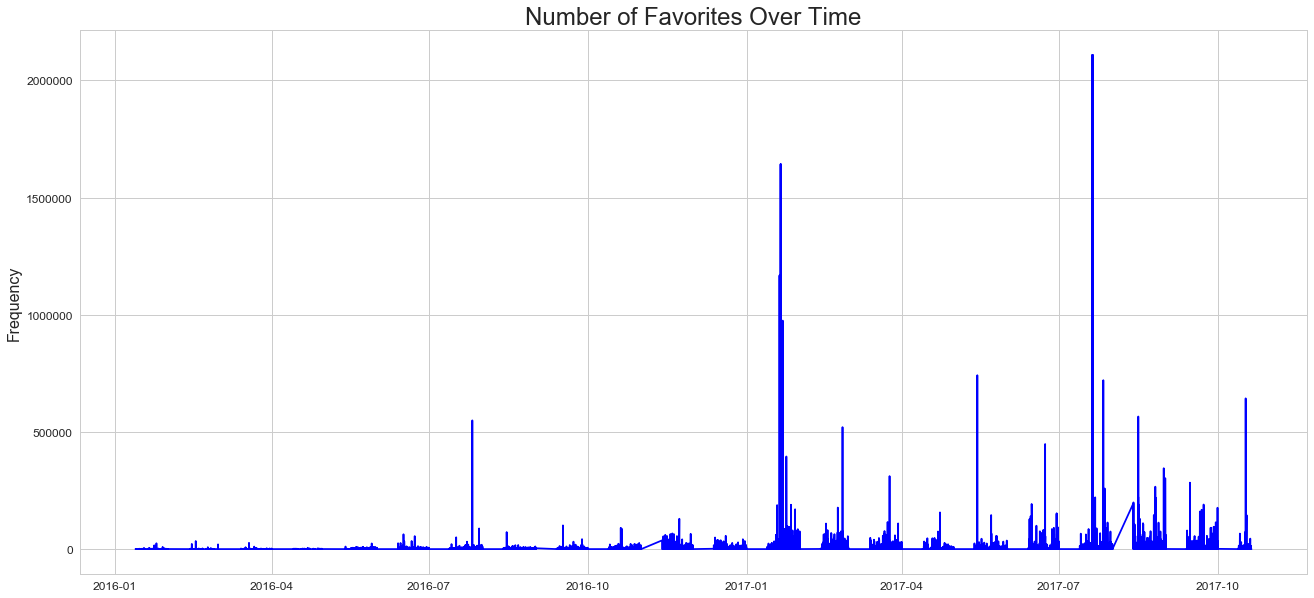

In [23]:
# Creating the favorites series
s = tweets_subset[['created_at', 'favorites']]
favorites = s.set_index('created_at')['favorites']

# Number of retweets over time
plot_series(favorites, title='Number of Favorites Over Time')

### Text Analysis

In [24]:
# Text corpus
document = [i for i in tweets.text]

# Removing common words and tokenizing
stop_words = set(stopwords.words('english'))
update_words = ['-', '=', '+', '*','.', ',', '"', "'", '?', '!', 'w/',
                ':', ';', 'heäó»ll', "i'd", '(and', "there's", '(', 
                ')', '[', ']', '{', '}', '&amp', '&amp;', '&', '$', 
                '^', '.*', '*.', 'äóìbest', 'adäó_', 'staäó_', "i'll",
                'worldäó_', 'hereäó»s', 'letäó»s', 'adminäó»s', '(who', 
                'haveäó_', 'äóñ', '--', '---', 'träó_', 'americaäó»s', 
                'andäó_', 'foräó_', 'cräó_', 'asäó_', 'täó_', 'wäó_', 
                'toäó_', "it'll", "i've", 'iäó»ll', 'here:', ':here',
                'https:äó_', 'httpsäó_']
stop_words.update(update_words)
for doc in document:
    list_of_words = [i.lower() for i in wordpunct_tokenize(doc) if i.lower() not in stop_words]
stop_words.update(list_of_words)

# Removing common words
texts = [[word for word in doc.lower().split() if word not in stop_words] for doc in document]

# Removing words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > 7] for text in texts]

# Create dictionary of the document
dictionary = corpora.Dictionary(texts)
dictionary.save('senator.dict')

# Converting document to a vector (bag-of-words)
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('senator.mm', corpus)

# Print done
print('Done!')

2018-07-04 17:48:40,725 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-07-04 17:48:40,878 : INFO : adding document #10000 to Dictionary(13530 unique tokens: ['bill', 'bipartisan', 'done.', 'get', 'healthcare']...)
2018-07-04 17:48:41,031 : INFO : adding document #20000 to Dictionary(18522 unique tokens: ['bill', 'bipartisan', 'done.', 'get', 'healthcare']...)
2018-07-04 17:48:41,181 : INFO : adding document #30000 to Dictionary(21456 unique tokens: ['bill', 'bipartisan', 'done.', 'get', 'healthcare']...)
2018-07-04 17:48:41,332 : INFO : adding document #40000 to Dictionary(23450 unique tokens: ['bill', 'bipartisan', 'done.', 'get', 'healthcare']...)
2018-07-04 17:48:41,486 : INFO : adding document #50000 to Dictionary(25040 unique tokens: ['bill', 'bipartisan', 'done.', 'get', 'healthcare']...)
2018-07-04 17:48:41,642 : INFO : adding document #60000 to Dictionary(26014 unique tokens: ['bill', 'bipartisan', 'done.', 'get', 'healthcare']...)
2018-07-04 17:48:41,792 :

2018-07-04 17:48:49,655 : INFO : PROGRESS: saving document #53000
2018-07-04 17:48:49,673 : INFO : PROGRESS: saving document #54000
2018-07-04 17:48:49,690 : INFO : PROGRESS: saving document #55000
2018-07-04 17:48:49,709 : INFO : PROGRESS: saving document #56000
2018-07-04 17:48:49,728 : INFO : PROGRESS: saving document #57000
2018-07-04 17:48:49,747 : INFO : PROGRESS: saving document #58000
2018-07-04 17:48:49,766 : INFO : PROGRESS: saving document #59000
2018-07-04 17:48:49,786 : INFO : PROGRESS: saving document #60000
2018-07-04 17:48:49,805 : INFO : PROGRESS: saving document #61000
2018-07-04 17:48:49,823 : INFO : PROGRESS: saving document #62000
2018-07-04 17:48:49,841 : INFO : PROGRESS: saving document #63000
2018-07-04 17:48:49,859 : INFO : PROGRESS: saving document #64000
2018-07-04 17:48:49,876 : INFO : PROGRESS: saving document #65000
2018-07-04 17:48:49,894 : INFO : PROGRESS: saving document #66000
2018-07-04 17:48:55,311 : INFO : PROGRESS: saving document #67000
2018-07-04

2018-07-04 17:48:58,387 : INFO : PROGRESS: saving document #176000
2018-07-04 17:49:01,253 : INFO : PROGRESS: saving document #177000
2018-07-04 17:49:01,272 : INFO : PROGRESS: saving document #178000
2018-07-04 17:49:01,289 : INFO : PROGRESS: saving document #179000
2018-07-04 17:49:01,322 : INFO : PROGRESS: saving document #180000
2018-07-04 17:49:01,342 : INFO : PROGRESS: saving document #181000
2018-07-04 17:49:01,358 : INFO : PROGRESS: saving document #182000
2018-07-04 17:49:01,393 : INFO : PROGRESS: saving document #183000
2018-07-04 17:49:01,413 : INFO : PROGRESS: saving document #184000
2018-07-04 17:49:01,430 : INFO : PROGRESS: saving document #185000
2018-07-04 17:49:01,733 : INFO : PROGRESS: saving document #186000
2018-07-04 17:49:01,755 : INFO : PROGRESS: saving document #187000
2018-07-04 17:49:01,775 : INFO : PROGRESS: saving document #188000
2018-07-04 17:49:01,809 : INFO : PROGRESS: saving document #189000
2018-07-04 17:49:01,830 : INFO : PROGRESS: saving document #19

Done!


***
#### Transformation: _Term Frequency - Inverse Document Frequency (TF-IDF)_

**tf-idf** is initialized with a **bag-of-words** (integer values) training corpus and takes in a vector, returning another vector of the same dimensionality. except that features which are rare in the training corpus will have their value increased. It therefore converts integer-valued vectors into real-valued ones, while leaving the number of dimensions intact. It can also, optionally, normalize the resulting vectors to (Euclidean) unit length.

##### Step 1:

In [25]:
# Initialization
tfidf = models.TfidfModel(corpus)

2018-07-04 17:49:13,968 : INFO : collecting document frequencies
2018-07-04 17:49:13,969 : INFO : PROGRESS: processing document #0
2018-07-04 17:49:14,005 : INFO : PROGRESS: processing document #10000
2018-07-04 17:49:14,036 : INFO : PROGRESS: processing document #20000
2018-07-04 17:49:14,066 : INFO : PROGRESS: processing document #30000
2018-07-04 17:49:14,098 : INFO : PROGRESS: processing document #40000
2018-07-04 17:49:14,128 : INFO : PROGRESS: processing document #50000
2018-07-04 17:49:14,158 : INFO : PROGRESS: processing document #60000
2018-07-04 17:49:14,186 : INFO : PROGRESS: processing document #70000
2018-07-04 17:49:14,217 : INFO : PROGRESS: processing document #80000
2018-07-04 17:49:14,246 : INFO : PROGRESS: processing document #90000
2018-07-04 17:49:14,280 : INFO : PROGRESS: processing document #100000
2018-07-04 17:49:14,311 : INFO : PROGRESS: processing document #110000
2018-07-04 17:49:14,342 : INFO : PROGRESS: processing document #120000
2018-07-04 17:49:14,374 : 

##### Step 2:

In [26]:
# Applying the transformation to the whole corpus
corpus_tfidf = tfidf[corpus]

#### Transformation: _Latent Semantic Indexing (LSI, or sometimes LSA)_

Transforms documents from either **bag-of-words** or (preferably) **tf-idf**-weighted space into a latent space of a lower dimensionality. 

**LSI** is unique in that we can continue "training" at any point, simply by providing more training documents. This is done by incremental updates to the underlying model, in a process called _online training_. Because of this feature, the input document stream may even be infinite - just keep feeding **LSI** new documents as they arrive, while using the computed transformation model as read-only in the meanwhile!

[gensim.models.lsimodel](https://radimrehurek.com/gensim/models/lsimodel.html#module-gensim.models.lsimodel) contains details for making an **LSI** model gradually "forget" old observations in infinite streams, with parameters that can be tweaked to affect speed, memory footprint and numerical precision of the **LSI** algorithm.

[___gensim___](https://radimrehurek.com/gensim) uses a novel online incremental streamed distributed training algorithm published [here](https://radimrehurek.com/gensim/tut2.html#id10). ___gensim___ also executes a stochastic multi-pass algorithm from [Halko et al.](https://radimrehurek.com/gensim/tut2.html#id9) internally, to accelerate in-core part of the computations.

In [27]:
# Initializing an LSI transformation
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=50)
corpus_lsi = lsi[corpus_tfidf]

2018-07-04 17:49:14,961 : INFO : using serial LSI version on this node
2018-07-04 17:49:14,963 : INFO : updating model with new documents
2018-07-04 17:49:15,987 : INFO : preparing a new chunk of documents
2018-07-04 17:49:16,097 : INFO : using 100 extra samples and 2 power iterations
2018-07-04 17:49:16,098 : INFO : 1st phase: constructing (30487, 150) action matrix
2018-07-04 17:49:16,254 : INFO : orthonormalizing (30487, 150) action matrix
2018-07-04 17:49:16,710 : INFO : 2nd phase: running dense svd on (150, 20000) matrix
2018-07-04 17:49:16,839 : INFO : computing the final decomposition
2018-07-04 17:49:16,840 : INFO : keeping 50 factors (discarding 44.687% of energy spectrum)
2018-07-04 17:49:16,861 : INFO : processed documents up to #20000
2018-07-04 17:49:16,871 : INFO : topic #0(10.104): 0.731*"inhofe" + 0.272*"sen." + 0.232*"w" + 0.131*"rt" + 0.111*"iowa" + 0.109*"#lasen" + 0.094*"good" + 0.089*"senate" + 0.088*"bill" + 0.084*"great"
2018-07-04 17:49:16,872 : INFO : topic #1(

2018-07-04 17:49:24,657 : INFO : topic #0(18.868): 0.339*"rt" + 0.179*"senate" + 0.165*"great" + 0.160*"health" + 0.149*"today" + 0.148*"bill" + 0.137*"thank" + 0.130*"care" + 0.128*"work" + 0.127*"thanks"
2018-07-04 17:49:24,659 : INFO : topic #1(13.363): -0.386*"great" + -0.318*"thank" + -0.317*"thanks" + 0.314*"health" + 0.261*"senate" + 0.256*"care" + 0.164*"bill" + -0.144*"happy" + 0.143*"mcconnell" + 0.115*"floor"
2018-07-04 17:49:24,660 : INFO : topic #2(13.062): -0.406*"rt" + 0.346*"health" + 0.293*"care" + -0.222*"sen." + -0.171*"mcconnell" + -0.164*"senate" + 0.160*"work" + -0.148*"live" + -0.145*"watch" + -0.138*"senator"
2018-07-04 17:49:24,662 : INFO : topic #3(12.478): -0.564*"rt" + 0.248*"mcconnell" + 0.239*".@senatemajldr" + 0.222*"great" + 0.209*"senate" + 0.161*"tune" + -0.153*"thank" + 0.146*"#kentucky" + 0.136*"live" + 0.127*"#mepolitics"
2018-07-04 17:49:24,663 : INFO : topic #4(12.074): 0.495*"mcconnell" + 0.422*".@senatemajldr" + -0.275*"tune" + 0.271*"#kentucky"

2018-07-04 17:49:32,814 : INFO : topic #4(15.678): -0.403*"health" + -0.336*"care" + -0.329*"rt" + -0.208*"great" + 0.195*"bill" + 0.181*"proud" + 0.176*"help" + -0.162*"tune" + -0.157*"live" + 0.157*"support"
2018-07-04 17:49:33,893 : INFO : preparing a new chunk of documents
2018-07-04 17:49:33,999 : INFO : using 100 extra samples and 2 power iterations
2018-07-04 17:49:34,000 : INFO : 1st phase: constructing (30487, 150) action matrix
2018-07-04 17:49:34,167 : INFO : orthonormalizing (30487, 150) action matrix
2018-07-04 17:49:34,621 : INFO : 2nd phase: running dense svd on (150, 20000) matrix
2018-07-04 17:49:34,742 : INFO : computing the final decomposition
2018-07-04 17:49:34,743 : INFO : keeping 50 factors (discarding 49.102% of energy spectrum)
2018-07-04 17:49:34,762 : INFO : merging projections: (30487, 50) + (30487, 50)
2018-07-04 17:49:34,807 : INFO : keeping 50 factors (discarding 11.651% of energy spectrum)
2018-07-04 17:49:34,829 : INFO : processed documents up to #20000

2018-07-04 17:49:42,560 : INFO : keeping 50 factors (discarding 9.776% of energy spectrum)
2018-07-04 17:49:42,583 : INFO : processed documents up to #280000
2018-07-04 17:49:42,585 : INFO : topic #0(30.990): 0.294*"rt" + 0.210*"great" + 0.188*"senate" + 0.176*"today" + 0.175*"health" + 0.171*"bill" + 0.150*"care" + 0.129*"thank" + 0.128*"thanks" + 0.126*"help"
2018-07-04 17:49:42,586 : INFO : topic #1(22.747): -0.532*"great" + 0.328*"health" + 0.288*"care" + -0.258*"thanks" + 0.206*"senate" + 0.206*"bill" + -0.188*"thank" + -0.146*"meeting" + -0.134*"happy" + -0.116*"today"
2018-07-04 17:49:42,588 : INFO : topic #2(21.222): 0.362*"health" + 0.322*"care" + -0.319*"watch" + -0.310*"senate" + -0.263*"live" + -0.248*"rt" + -0.200*"floor" + -0.189*"tune" + 0.178*"great" + -0.168*"hearing"
2018-07-04 17:49:42,589 : INFO : topic #3(20.139): -0.501*"rt" + 0.381*"great" + -0.344*"thank" + 0.203*"health" + 0.193*"senate" + -0.192*"happy" + 0.179*"watch" + 0.174*"care" + 0.146*"live" + 0.145*"tu

In [28]:
lsi.print_topics(10)

2018-07-04 17:49:43,735 : INFO : topic #0(31.498): 0.304*"rt" + 0.211*"great" + 0.186*"senate" + 0.176*"health" + 0.173*"today" + 0.169*"bill" + 0.150*"care" + 0.132*"thank" + 0.130*"thanks" + 0.124*"help"
2018-07-04 17:49:43,737 : INFO : topic #1(23.109): -0.530*"great" + 0.337*"health" + 0.296*"care" + -0.257*"thanks" + 0.204*"bill" + 0.200*"senate" + -0.190*"thank" + -0.146*"meeting" + -0.131*"happy" + -0.113*"today"
2018-07-04 17:49:43,738 : INFO : topic #2(21.528): 0.366*"health" + 0.326*"care" + -0.303*"watch" + -0.296*"senate" + -0.296*"rt" + -0.251*"live" + 0.217*"great" + -0.191*"floor" + -0.179*"tune" + -0.159*"hearing"
2018-07-04 17:49:43,740 : INFO : topic #3(20.532): -0.519*"rt" + 0.363*"great" + -0.361*"thank" + 0.228*"senate" + 0.195*"watch" + -0.183*"happy" + 0.159*"live" + 0.154*"tune" + 0.149*"floor" + 0.140*"health"
2018-07-04 17:49:43,741 : INFO : topic #4(19.598): -0.441*"rt" + -0.383*"health" + -0.325*"care" + 0.191*"help" + -0.168*"thanks" + 0.167*"senate" + 0.15

[(0,
  '0.304*"rt" + 0.211*"great" + 0.186*"senate" + 0.176*"health" + 0.173*"today" + 0.169*"bill" + 0.150*"care" + 0.132*"thank" + 0.130*"thanks" + 0.124*"help"'),
 (1,
  '-0.530*"great" + 0.337*"health" + 0.296*"care" + -0.257*"thanks" + 0.204*"bill" + 0.200*"senate" + -0.190*"thank" + -0.146*"meeting" + -0.131*"happy" + -0.113*"today"'),
 (2,
  '0.366*"health" + 0.326*"care" + -0.303*"watch" + -0.296*"senate" + -0.296*"rt" + -0.251*"live" + 0.217*"great" + -0.191*"floor" + -0.179*"tune" + -0.159*"hearing"'),
 (3,
  '-0.519*"rt" + 0.363*"great" + -0.361*"thank" + 0.228*"senate" + 0.195*"watch" + -0.183*"happy" + 0.159*"live" + 0.154*"tune" + 0.149*"floor" + 0.140*"health"'),
 (4,
  '-0.441*"rt" + -0.383*"health" + -0.325*"care" + 0.191*"help" + -0.168*"thanks" + 0.167*"senate" + 0.158*"proud" + 0.157*"bill" + -0.140*"live" + 0.136*"support"'),
 (5,
  '-0.607*"happy" + -0.351*"thank" + 0.276*"rt" + -0.256*"birthday" + 0.159*"thanks" + -0.153*"live" + -0.151*"watch" + -0.150*"health" 

| Top 5 Topics from Latent Semantic Indexing (LSI) |
| --- |
| **1** | _"rt", "great", "senate", "health", "today", "bill", "care", "thanks", "thank", "help"_ | **Description:** | Retweets of tweets related to a health care bill with "thanks" for "help". |
| **2** | _"great", "health", "care", "thanks", "bill", "senate", "thank", "meeting", "happy", "today"_ | **Description:** | Tweets related to health care bill with references to a "happy meeting". |
| **3** | _"health", "care", "watch", "rt", "senate", "live", "great", "floor", "tune", "hearing"_ | **Description:** | Tweets referencing a health care bill & watching or tuning into a live broadcast of a hearing. |
| **4** | _"rt", "thank", "great", "senate", "watch", "happy", "live", "tune", "floor", "health"_ | **Description:** | Retweets with commentary of giving thanks of a live screening related to health. |
| **5** | _"rt", "health", "care", "help", "senate", "happy", "thanks", "proud", "bill", "live"_ | **Description:** | Retweets of tweets related to a health care bill with senate being happy and proud of the bill. |

In [29]:
# Model persistence
lsi.save('senator.lsi')
lsi = models.LsiModel.load('senator.lsi')

2018-07-04 17:49:43,756 : INFO : saving Projection object under senator.lsi.projection, separately None
2018-07-04 17:49:53,327 : INFO : saved senator.lsi.projection
2018-07-04 17:49:53,329 : INFO : saving LsiModel object under senator.lsi, separately None
2018-07-04 17:49:53,330 : INFO : not storing attribute projection
2018-07-04 17:49:53,331 : INFO : not storing attribute dispatcher
2018-07-04 17:49:53,350 : INFO : saved senator.lsi
2018-07-04 17:49:53,351 : INFO : loading LsiModel object from senator.lsi
2018-07-04 17:49:53,772 : INFO : loading id2word recursively from senator.lsi.id2word.* with mmap=None
2018-07-04 17:49:53,773 : INFO : setting ignored attribute projection to None
2018-07-04 17:49:53,773 : INFO : setting ignored attribute dispatcher to None
2018-07-04 17:49:53,774 : INFO : loaded senator.lsi
2018-07-04 17:49:53,775 : INFO : loading LsiModel object from senator.lsi.projection
2018-07-04 17:49:53,851 : INFO : loaded senator.lsi.projection


***
#### Similarity
##### Step 1:

In [30]:
# Initializing the query structure: transform corpus to LSI space and index it
index = similarities.MatrixSimilarity(lsi[corpus], num_features=50)

# Index persistence
index.save('senator.index')
index = similarities.MatrixSimilarity.load('senator.index')

2018-07-04 17:49:53,856 : INFO : creating matrix with 288615 documents and 50 features
2018-07-04 17:50:11,584 : INFO : saving MatrixSimilarity object under senator.index, separately None
2018-07-04 17:50:11,584 : INFO : storing np array 'index' to senator.index.index.npy
2018-07-04 17:50:41,374 : INFO : saved senator.index
2018-07-04 17:50:41,375 : INFO : loading MatrixSimilarity object from senator.index
2018-07-04 17:50:41,519 : INFO : loading index from senator.index.index.npy with mmap=None
2018-07-04 17:50:41,699 : INFO : loaded senator.index


##### Step 2:

In [31]:
# Performing queries
doc = "Hospital"
vec_bow = dictionary.doc2bow(doc.lower().split())

# Convert the query to LSI spaace
vec_lsi = lsi[vec_bow]

# Perform a similarity query against the corpus
sims = index[vec_lsi]

# Ranking the tweets by their weights of similarity
sims = sorted(enumerate(sims), key=lambda item: -item[1])

# Printing the associated tweets:
for i in range(10):
    print("Tweet Rank #{}:\tWeights {}\nRaw Text: {}\n".format(i+1, sims[i][1], document[sims[i][0]]))

Tweet Rank #1:	Weights 1.0
Raw Text: Very clever bedpan art! @PHXChildrens Hospital https://t.co/G8gLKBSRFd

Tweet Rank #2:	Weights 0.8116185665130615
Raw Text: Toured Hagie mfg. In wright co. 55 employees asked abt:corp tax,high value of dollar,# 1äó_ https://t.co/15STugNGG7

Tweet Rank #3:	Weights 0.808225154876709
Raw Text: Talked about the issues our manufacturers face on my tour of the Plastic Professionals in Cass County. #99CountyTour https://t.co/Zha63TlfJ2

Tweet Rank #4:	Weights 0.7995813488960266
Raw Text: Visited Ottawa and Naplate this afternoon to tour the damage from the severe storms and tornadoes that hit LaSalleäó_ https://t.co/M2mcfawJxo

Tweet Rank #5:	Weights 0.7963957190513611
Raw Text: Keith Blake of Swiss Valley Farms talked to me about GMO labeling. He's from Eldridge https://t.co/o7UVZDWnvE

Tweet Rank #6:	Weights 0.791307270526886
Raw Text: Lewis and Clark Home Builders Association hosted a round table and we talked about regulations impacting their induäó_ h

#### Transformation:  _Latent Dirichlet Allocation (LDA)_

**LDA** is a transformation from **bag-of-words** counts into a topic space of lower dimensionality. **LDA** is an extension of **LSA** (also called ___multinomial PCA___), so **LDA**'s topics can be interpreted as probability distributions over words. These distributions are, just like with **LSA**, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics (just like **LSA**).

In [32]:
# Batch LDA: extract 50 LDA topics, using 1 pass updating once every chunk (10,000 documents)
lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=50, update_every=1, passes=1, chunksize=10000)

# Model persistance
lda.save('senator.lda')
lda = models.ldamodel.LdaModel.load('senator.lda')

2018-07-04 17:50:42,003 : INFO : using symmetric alpha at 0.02
2018-07-04 17:50:42,004 : INFO : using symmetric eta at 0.02
2018-07-04 17:50:42,009 : INFO : using serial LDA version on this node
2018-07-04 17:50:42,186 : INFO : running online (single-pass) LDA training, 50 topics, 1 passes over the supplied corpus of 288615 documents, updating model once every 10000 documents, evaluating perplexity every 100000 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-04 17:50:42,187 : INFO : PROGRESS: pass 0, at document #10000/288615
2018-07-04 17:50:46,021 : INFO : merging changes from 10000 documents into a model of 288615 documents
2018-07-04 17:50:46,179 : INFO : topic #26 (0.020): 0.013*"rt" + 0.010*"#lasen" + 0.009*"thank" + 0.008*"help" + 0.007*"new" + 0.007*"thanks" + 0.006*"w" + 0.006*"good" + 0.006*"great" + 0.006*"health"
2018-07-04 17:50:46,181 : INFO : topic #22 (0.020): 0.010*"great" + 0.009*"bill" + 0.009*"tune" + 0.008*"today" + 0.008*"need" + 0.007*"h

2018-07-04 17:51:00,420 : INFO : topic diff=0.482756, rho=0.408248
2018-07-04 17:51:00,423 : INFO : PROGRESS: pass 0, at document #70000/288615
2018-07-04 17:51:02,781 : INFO : merging changes from 10000 documents into a model of 288615 documents
2018-07-04 17:51:02,950 : INFO : topic #21 (0.020): 0.010*"serious" + 0.009*"need" + 0.009*"trump" + 0.008*"long" + 0.008*"fight" + 0.008*"rights." + 0.008*"w/o" + 0.008*"would" + 0.007*"broken" + 0.007*"protect"
2018-07-04 17:51:02,952 : INFO : topic #1 (0.020): 0.023*"bill" + 0.017*"court" + 0.015*"supreme" + 0.013*"alaska" + 0.012*"@mikecrapo" + 0.011*"senate" + 0.011*"strengthen" + 0.010*"rt" + 0.010*"passed" + 0.009*"help"
2018-07-04 17:51:02,953 : INFO : topic #13 (0.020): 0.020*"courthouse" + 0.017*"rt" + 0.016*"help" + 0.015*"coal" + 0.012*"stop" + 0.012*"saudi" + 0.010*"internet" + 0.010*"family" + 0.010*"little" + 0.009*"#coal"
2018-07-04 17:51:02,954 : INFO : topic #19 (0.020): 0.015*"lot" + 0.012*"afford" + 0.012*"friend" + 0.011*"

2018-07-04 17:51:17,874 : INFO : topic diff=0.374423, rho=0.288675
2018-07-04 17:51:17,877 : INFO : PROGRESS: pass 0, at document #130000/288615
2018-07-04 17:51:19,894 : INFO : merging changes from 10000 documents into a model of 288615 documents
2018-07-04 17:51:20,070 : INFO : topic #21 (0.020): 0.015*"long" + 0.014*"lose" + 0.013*"russian" + 0.012*"election" + 0.011*"@senatorisakson" + 0.011*"process" + 0.010*"must" + 0.010*"serious" + 0.010*"need" + 0.009*"protect"
2018-07-04 17:51:20,071 : INFO : topic #46 (0.020): 0.050*"rt" + 0.024*"@senatorrounds" + 0.021*"repeal" + 0.015*"https://äó_" + 0.011*"obamacare" + 0.011*"remarks" + 0.010*"breaking:" + 0.010*"addiction" + 0.010*"heroin" + 0.010*"@realdonaldtrump"
2018-07-04 17:51:20,073 : INFO : topic #33 (0.020): 0.056*"forward" + 0.036*"look" + 0.035*"looking" + 0.023*"enjoyed" + 0.021*"city" + 0.020*"great" + 0.020*"today" + 0.018*"thanks" + 0.015*"visiting" + 0.014*"conversation"
2018-07-04 17:51:20,074 : INFO : topic #22 (0.020):

2018-07-04 17:51:32,630 : INFO : merging changes from 10000 documents into a model of 288615 documents
2018-07-04 17:51:32,805 : INFO : topic #41 (0.020): 0.090*"health" + 0.072*"care" + 0.035*"would" + 0.024*"bill" + 0.023*"access" + 0.016*"gop" + 0.015*"better" + 0.015*"insurance" + 0.014*"#trumpcare" + 0.013*"affordable"
2018-07-04 17:51:32,807 : INFO : topic #24 (0.020): 0.028*"questions" + 0.022*"indiana" + 0.021*"follow" + 0.020*"more." + 0.017*"hassan" + 0.016*"foreign" + 0.015*"policy" + 0.014*"#sfrc" + 0.013*"people." + 0.013*"answers"
2018-07-04 17:51:32,808 : INFO : topic #10 (0.020): 0.030*"#mtpol" + 0.028*"rural" + 0.021*"following" + 0.019*"farmers" + 0.018*"leading" + 0.017*"gov." + 0.016*"communities." + 0.014*"confirmation" + 0.012*"gen." + 0.012*"gave"
2018-07-04 17:51:32,809 : INFO : topic #15 (0.020): 0.032*"joeäó»s" + 0.026*"nuclear" + 0.026*"co" + 0.022*"iran" + 0.017*"#irandeal" + 0.017*"deal" + 0.015*"west" + 0.013*"raise" + 0.013*"residents" + 0.013*"historic"


2018-07-04 17:51:47,976 : INFO : merging changes from 10000 documents into a model of 288615 documents
2018-07-04 17:51:48,155 : INFO : topic #21 (0.020): 0.020*"political" + 0.019*"long" + 0.017*"serious" + 0.016*"must" + 0.015*"rights" + 0.015*"lose" + 0.014*"russian" + 0.014*"need" + 0.013*"process" + 0.012*"trump"
2018-07-04 17:51:48,157 : INFO : topic #40 (0.020): 0.053*"right" + 0.019*"now." + 0.018*"trump's" + 0.017*"clear" + 0.014*"decision" + 0.013*"nothing" + 0.012*"pres" + 0.011*"must" + 0.011*"america's" + 0.010*"takes"
2018-07-04 17:51:48,158 : INFO : topic #23 (0.020): 0.030*".@senronjohnson" + 0.014*"progress" + 0.014*"@senjohnbarrasso" + 0.013*"member" + 0.013*"theäó_" + 0.013*"committed" + 0.012*"mental" + 0.012*"troops" + 0.011*"#stopact" + 0.011*"keep"
2018-07-04 17:51:48,159 : INFO : topic #19 (0.020): 0.026*"water" + 0.025*"friend" + 0.019*"afford" + 0.018*"passing" + 0.014*"lot" + 0.014*"citizens" + 0.013*"affected" + 0.013*"@senjohnmccain" + 0.013*"river" + 0.012

In [33]:
# Top contributing words for 10 randomly selected topics
lda.print_topics(10)

2018-07-04 17:52:03,207 : INFO : topic #7 (0.020): 0.023*"executive" + 0.021*"order" + 0.021*"dangerous" + 0.019*"trumpäó»s" + 0.017*"past" + 0.016*"tech" + 0.015*"wonäó»t" + 0.011*"govt" + 0.011*"spend" + 0.010*"saw"
2018-07-04 17:52:03,209 : INFO : topic #25 (0.020): 0.033*"last" + 0.027*"letter" + 0.019*"night" + 0.019*"effort" + 0.018*"urging" + 0.014*"rt" + 0.014*"video" + 0.013*"heard" + 0.012*"sent" + 0.011*"huge"
2018-07-04 17:52:03,210 : INFO : topic #8 (0.020): 0.047*"rt" + 0.039*"energy" + 0.035*"listen" + 0.018*"hold" + 0.018*"clean" + 0.018*"httpäó_" + 0.016*"senate" + 0.016*"threat" + 0.013*"rules" + 0.012*"resources"
2018-07-04 17:52:03,211 : INFO : topic #45 (0.020): 0.057*"office" + 0.032*"staff" + 0.025*"town" + 0.022*"@marcorubio" + 0.020*"hall" + 0.018*"dc" + 0.016*"history" + 0.016*"today!" + 0.014*"@senategop" + 0.014*"thx"
2018-07-04 17:52:03,212 : INFO : topic #36 (0.020): 0.054*"rt" + 0.026*"mt" + 0.024*"@timkaine" + 0.023*"earlier" + 0.021*"@senpatroberts" + 0

[(7,
  '0.023*"executive" + 0.021*"order" + 0.021*"dangerous" + 0.019*"trumpäó»s" + 0.017*"past" + 0.016*"tech" + 0.015*"wonäó»t" + 0.011*"govt" + 0.011*"spend" + 0.010*"saw"'),
 (25,
  '0.033*"last" + 0.027*"letter" + 0.019*"night" + 0.019*"effort" + 0.018*"urging" + 0.014*"rt" + 0.014*"video" + 0.013*"heard" + 0.012*"sent" + 0.011*"huge"'),
 (8,
  '0.047*"rt" + 0.039*"energy" + 0.035*"listen" + 0.018*"hold" + 0.018*"clean" + 0.018*"httpäó_" + 0.016*"senate" + 0.016*"threat" + 0.013*"rules" + 0.012*"resources"'),
 (45,
  '0.057*"office" + 0.032*"staff" + 0.025*"town" + 0.022*"@marcorubio" + 0.020*"hall" + 0.018*"dc" + 0.016*"history" + 0.016*"today!" + 0.014*"@senategop" + 0.014*"thx"'),
 (36,
  '0.054*"rt" + 0.026*"mt" + 0.024*"@timkaine" + 0.023*"earlier" + 0.021*"@senpatroberts" + 0.021*"leader" + 0.019*"mr." + 0.018*"#iran" + 0.013*"majority" + 0.011*"run"'),
 (9,
  '0.060*"go" + 0.021*"resolution" + 0.019*"immigration" + 0.019*"wants" + 0.015*"coverage" + 0.013*"@corybooker" + 0.

| **Top 5 Randomly Selected Topics from Latent Dirichlet Allocation (LDA)** |
| :---: | --- | :---: | --- |
| **19** | _"right", "@marcorubio", "long", "signed", "communities", "now.", "@senpatroberts", "rt", "things", "historic"_ | **Description:** | Tweets related to the right mentioning [Marco Rubio](https://en.wikipedia.org/wiki/Marco_Rubio) and senator [Pat Roberts](https://en.wikipedia.org/wiki/Pat_Roberts) with retweets references to historic events and communities. |
| **42** | _"mr.", "rt", "nothing", "us", "become", "toward", "behind", "anyone", "actions", "fought"_ | **Description:** | Topic 43 (index is 0) does not seem to have a coherent topic of reference.* |
| **47** | _"happy", "birthday", "helping", "arkansas", "celebrating", "rt", "https://t.äó_", "thank", "grant", "#tbt"_ | **Description:** | Topic 48 contains birthday celebration references with the hashtag "#tbt" (Throw-Back-Thursday or is it Tuesday?). |
| **12** | _"rt", "@stevedaines", "senator", "defense", "https:/äó_", "award", "receive", "https://täó_", "sen.", "key"'_ | **Description:** | This topic references retweets with mentions of senator [Steve Daines](https://en.wikipedia.org/wiki/Steve_Daines), receiving a defense awared. |
| **0** | _"county", "today!", "todayäó»s", "press", "visiting", "conference", "rt", "past", "following", "ohioans"_ | **Description:** | Tweets related to a county in Ohio with press conference news retweets.* |

### Summary

At this point, we observe that **LDA** provides topic models with better coherent semantic reference compared to **LDA**, which seems to contain words with a hidden reference.

***

### Clustering Sentiments

To cluster sentiments, we will use the `k-means` algorithm from a ***bag-of-words*** approach. This implies that we will be using the sparse matrix as oppossed to standard arrays.

We will use the `gensim.matutils.corpus2csc()` function to convert our streamed corpus in ***bag-of-words*** format into a sparse matrix with documents as columns.

In [34]:
# Converting the corpus into a sparse matrix
print('Creating sparse matrix ...')
corpus_sparse_matrix = gensim.matutils.corpus2csc(corpus_tfidf)
print('Done!')

# K-means model
print('K-Means Model')
print('Initializing ...')
km = KMeans(n_clusters=50)

# Fitting
print('Fitting ...')
t0 = time()
km.fit(corpus_sparse_matrix)
duration = time() - t0
print('Complete!')
print('Time to fit model: {}'.format(duration))
sparse_clusters = km.labels_.tolist()

Creating sparse matrix ...
Done!
K-Means Model
Initializing ...
Fitting ...
Complete!
Time to fit model: 194.72323608398438


In [ ]:
# Converting the corpus into a dense matrix
print('Condensing the corpus ...')
corpus_dense_matrix = gensim.matutils.corpus2dense(corpus_tfidf, num_terms=len(dictionary))
print('Done!')

# Fitting
print('Fitting ...')
t0 = time()
km.fit(corpus_dense_matrix)
duration = time() - t0
print('Complete!')
print('Time to fit model: {}'.format(duration))
dense_clusters = km.labels_.tolist()

Condensing the corpus ...


In [ ]:
assert(len(dictionary)==len(clusters))